In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import gc

In [ ]:
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from prettytable import PrettyTable
from sklearn import preprocessing

In [ ]:
# Main Model
!pip install torch pytorch-tabnet shap

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
import shap

In [ ]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection, DropHighPSIFeatures

from sklearn.pipeline import Pipeline

In [ ]:
import plotly.express as px

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
np.random.seed(42)

# **Preprocessing**

Next we started to fill (Nan) of numerical data with a simple mean Imputer, then applied a Standard scalar operation on it.

For the categorical Features, we used a simple Imputer filling the Nan values with the most repeated values in each of its columns. Next we used OneHotEncoder for each of its unique values.

In [ ]:
loaded_df_pickle = pd.read_pickle('/content/drive/MyDrive/Datasets/dataset/merge_train.pkl')

In [ ]:
loaded_df_test = pd.read_pickle('/content/drive/MyDrive/Datasets/dataset/merged_test.pkl')

In [ ]:
y = loaded_df_pickle["isFraud"]

Number of Class 0: 569877, Number of Class 1: 20663


<BarContainer object of 2 artists>

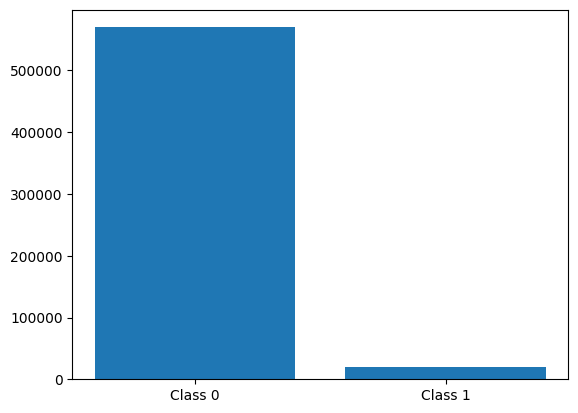

In [ ]:
print(f'Number of Class 0: {len(y)-sum(y)}, Number of Class 1: {sum(y)}')
plt.bar(['Class 0', 'Class 1'], [len(y)-sum(y), sum(y)])
plt.show()

We have very high Class dissparity

## Feature Engineering

In [ ]:
data = pd.concat([loaded_df_pickle, loaded_df_test], axis=0)
data['dataset'] = data['isFraud'].apply(lambda x: 'test' if np.isnan(x) else 'train')

In [ ]:
del loaded_df_pickle
del loaded_df_test

In [ ]:
import gc

In [ ]:
gc.collect()

0

In [ ]:
import datetime

START_DATE = '2023-01-05'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
data["datetime"] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
data['date'] = pd.to_datetime(data['datetime'].dt.date)
data['month'] = data['datetime'].dt.month
data['weekday'] = data['datetime'].dt.dayofweek
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.day

In [ ]:
transaction_ts = pd.Series(data['TransactionAmt'].values, index=data["datetime"])

In [ ]:
fig1 = px.line(
    x=transaction_ts.resample('D').sum().index,
    y=transaction_ts.resample('D').sum().values,
    title='Daily Sum of Transaction Amount')

fig1.show()

fig2 = px.line(
    x=transaction_ts.resample('D').mean().index,
    y=transaction_ts.resample('D').mean().values,
    title='Daily Avg of Transaction Amount')

fig2.show()

fig3 = px.line(
    x=transaction_ts.resample('D').count().index,
    y=transaction_ts.resample('D').count().values,
    title='Daily Transaction Amount')

fig3.show()

In [ ]:
dow_average = data.groupby('weekday')['TransactionAmt'].mean()
dow_std = data.groupby('weekday')['TransactionAmt'].std()
daily_avg = data['weekday'].apply(lambda x: dow_average[x] )
daily_std = data['weekday'].apply(lambda x: dow_std[x] )
data['TransactionAmt_norm'] = (data['TransactionAmt'] - daily_avg) / daily_std

In [ ]:
last_week_avg = transaction_ts.resample("D").mean().shift(7)
last_week_avg = last_week_avg.fillna(last_week_avg.median())

last_week_avg = data['date'].apply(lambda x: last_week_avg[x])
data['TransactionAmt_lastweek_norm'] = data['TransactionAmt'] / last_week_avg
transaction_norm_ts = pd.Series(data['TransactionAmt'].values, index=data["datetime"])


In [ ]:
fig2 = px.line(
    x=transaction_norm_ts.resample('D').mean().index,
    y=transaction_norm_ts.resample('D').mean().values,
    title='Daily Avg of Transaction Amount')
fig2.show()

## Looking into other features to analyze trends intution

Number of unique values in ProductCD: 5
We found out the relationship between the 5 products occurance rate, mean TransactionAmt for them and percent of Fraudulent activity in them to check the highest suspectable prodects

In [ ]:
# fininding frequency of the products
products = loaded_df_pickle['ProductCD'].unique()
vals = []
for i in products:
  print(f"COunt of {i}: {sum(list(loaded_df_pickle['ProductCD']==i))}")
  vals.append(sum(list(loaded_df_pickle['ProductCD']==i)))

COunt of W: 439670
COunt of H: 33024
COunt of C: 68519
COunt of S: 11628
COunt of R: 37699


In [ ]:
vals = [x for _, x in sorted(zip(products, vals))]

In [ ]:
# Finding number of occurances of Class 1 and Class 0 for each of the products
class_counts = loaded_df_pickle.groupby('ProductCD')['isFraud'].value_counts().unstack().fillna(0)
class_counts

isFraud,0,1
ProductCD,,
C,60511,8008
H,31450,1574
R,36273,1426
S,10942,686
W,430701,8969


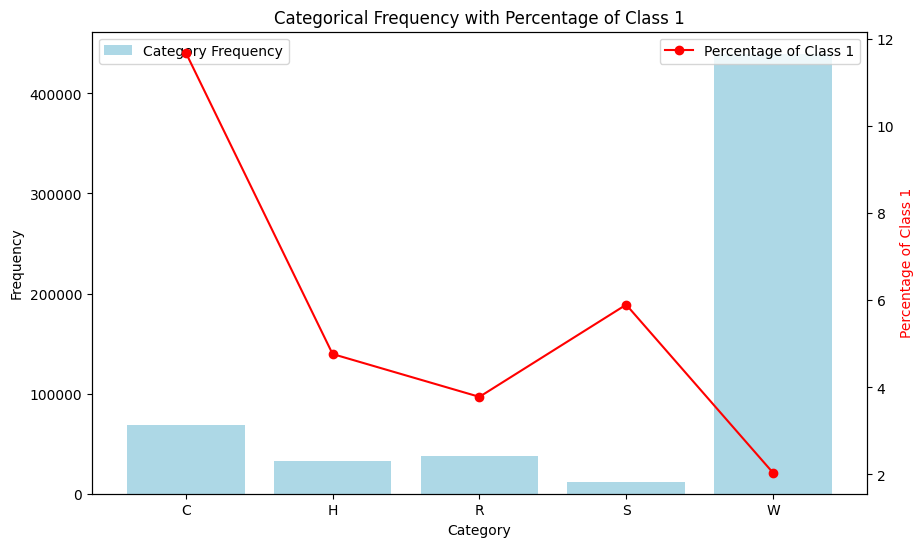

In [ ]:
class1_percentages = (class_counts[1] / (class_counts[0] + class_counts[1])) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.bar(np.sort((products)), vals, color='lightblue', label='Category Frequency')
ax2 = ax1.twinx()
ax2.plot(np.sort((products)), class1_percentages, marker='o', color='red', label='Percentage of Class 1')

ax1.set_xlabel('Category')
ax1.set_ylabel('Frequency', color='black')
ax2.set_ylabel('Percentage of Class 1', color='red')
plt.title('Categorical Frequency with Percentage of Class 1')

# Show the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

From Above graph we can see that Even though Product C and S have very low frequecy of occurance, they still have a high possibility of being a fraudulant transaction. Hence we can say there will be a higher probability of Flag for these products

___________________

## **Feature Analysing and Cleaning**

Correcting the Categorical Data columns

In [ ]:
data['p_r_domain'] = data['P_emaildomain'] == data['R_emaildomain']

In [ ]:
current_categorical_columns = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5','card6', 'addr1', 'addr2',\
                       'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13',
                       'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33',
                       'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [ ]:
data['device'] = data['DeviceInfo'].apply(lambda x: 'samsung' if 'sm' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'samsung' if 'samsung' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'moto' if 'moto' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'lenovo' if 'lenovo' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'huawei' if 'huawei' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'redmi' if 'redmi' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'lg' if 'lg' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'nokia' if 'nokia' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'pixel' if 'pixel' in str(x).lower() else x)
data['device'] = data['device'].apply(lambda x: 'rv' if 'rv' in str(x).lower() else x)

In [ ]:
data['p_email_domain_first'] = data['P_emaildomain'].apply(lambda x: str(x).split('.')[0])
data['p_email_domain_second'] = data['P_emaildomain'].apply(
    lambda x: str(x).split('.')[1] if len(str(x).split('.')) > 1 else "not_set"
)

In [ ]:
data['r_email_domain_first'] = data['R_emaildomain'].apply(lambda x: str(x).split('.')[0])
data['r_email_domain_second'] = data['R_emaildomain'].apply(
    lambda x: str(x).split('.')[1] if len(str(x).split('.')) > 1 else "not_set"
)

In [ ]:
data['browser'] = data['id_31'].apply(lambda x: 'chrome' if 'chrome' in str(x).lower() else x)
data['browser'] = data['browser'].apply(lambda x: 'edge' if 'edge' in str(x).lower() else x)
data['browser'] = data['browser'].apply(lambda x: 'safari' if 'safari' in str(x).lower() else x)
data['browser'] = data['browser'].apply(lambda x: 'opera' if 'opera' in str(x).lower() else x)
data['browser'] = data['browser'].apply(lambda x: 'firefox' if 'firefox' in str(x).lower() else x)
data['browser'] = data['browser'].apply(lambda x: 'google' if 'google' in str(x).lower() else x)
data['browser'] = data['browser'].apply(lambda x: 'blackberry' if 'blackberry' in str(x).lower() else x)
data['browser'] = data['browser'].apply(lambda x: 'samsung' if 'samsung' in str(x).lower() else x)
data['browser'] = data['browser'].apply(lambda x: 'ie' if 'ie ' in str(x).lower() else x)


In [ ]:
data['os'] = data['id_30'].apply(lambda x: 'windows' if 'windows' in str(x).lower() else x)
data['os'] = data['os'].apply(lambda x: 'ios' if 'ios' in str(x).lower() else x)
data['os'] = data['os'].apply(lambda x: 'mac' if 'mac' in str(x).lower() else x)
data['os'] = data['os'].apply(lambda x: 'android' if 'android' in str(x).lower() else x)
data['os'] = data['os'].apply(lambda x: 'linux' if 'linux' in str(x).lower() else x)

In [ ]:
# Checking Card1 - Card6
categorical_file1 = ['card1', 'card2', 'card3','card4', 'card5', 'card6']
for i in categorical_file1:
  print(loaded_df_pickle[i].describe())
  print(f'Null numbers: {loaded_df_pickle[i].isnull().sum()}')
  print()

count    590540.000000
mean       9898.734658
std        4901.170153
min        1000.000000
25%        6019.000000
50%        9678.000000
75%       14184.000000
max       18396.000000
Name: card1, dtype: float64
Null numbers: 0

count    581607.000000
mean        362.555488
std         157.793246
min         100.000000
25%         214.000000
50%         361.000000
75%         512.000000
max         600.000000
Name: card2, dtype: float64
Null numbers: 8933

count    588975.000000
mean        153.194925
std          11.336444
min         100.000000
25%         150.000000
50%         150.000000
75%         150.000000
max         231.000000
Name: card3, dtype: float64
Null numbers: 1565

count     588963
unique         4
top         visa
freq      384767
Name: card4, dtype: object
Null numbers: 1577

count    586281.000000
mean        199.278897
std          41.244453
min         100.000000
25%         166.000000
50%         226.000000
75%         226.000000
max         237.000000
Name: ca

We can see that Card4 and Card6 is of object type and the rest are float. There are empty values from Card2 to Card 6

https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage

Function taken from above site to lower memory usage by dataset for colab constraints

In [ ]:
for i in data.columns:
  print(i)

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:

           if col_type == 'datetime64[ns]':
            continue

            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 1198.26 MB
Memory usage after optimization is: 1148.08 MB
Decreased by 4.2%


In [ ]:
cat_features = [
    'hour', 'weekday', 'day', 'p_r_domain', 'os','browser', 'device',
    'p_email_domain_first', 'p_email_domain_second', 'r_email_domain_first',
    'r_email_domain_second', 'ProductCD', 'card1', 'card2', 'card3',
    'card4', 'card5', 'card6', 'addr1', 'addr2', 'M1',
    'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
    'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]

data[cat_features] = data[cat_features].astype(str)

In [ ]:
exclude = ['TransactionID', 'TransactionDT', 'isFraud', 'month', 'avg_last_day', 'std_last_day',
       'avg_last_hour', 'std_last_hour', 'avg_last_week', 'std_last_week', 'is_mobile', 'P_emaildomain',
           'R_emaildomain', 'DeviceInfo', 'dataset', 'datetime', 'date', 'id_30', 'id_31']
num_features = [f for f in data.columns if (f not in cat_features) & (f not in exclude)]

In [ ]:
print(train[num_features+cat_features].sample(frac=0.2).shape)

(118108, 477)


In [ ]:
train = data.loc[data['dataset'] == 'train', :]
test = data.loc[data['dataset'] == 'test', :]


In [ ]:
train.shape

(590540, 489)

In [ ]:
test.shape

(506691, 489)

In [ ]:
const_dropper = DropConstantFeatures(tol=0.99, missing_values='ignore')
corr_dropper = SmartCorrelatedSelection(method='spearman', selection_method='cardinality', missing_values='ignore')

select_pipe = Pipeline([
    ('constant', const_dropper),
    ('correlated', corr_dropper),
])


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

_____________________

In [ ]:
gc.collect()

0

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

In [ ]:
# Check if the train DataFrame is empty
if train.empty:
    print("Error: Training data is empty.")
else:
    # Feature selection transformers
    const_dropper = DropConstantFeatures(tol=0.99, missing_values='ignore')
    corr_dropper = SmartCorrelatedSelection(method='spearman', selection_method='cardinality', missing_values='ignore')

    # Sample a subset of the training data
    selected_data = train[num_features + cat_features].sample(frac=0.2)

    # Check if the selected_data DataFrame is empty
    if selected_data.empty:
        print("Error: Selected data is empty.")
    else:
        # Apply constant feature dropping
        selected_data_const = const_dropper.fit_transform(selected_data)

        # Apply correlated feature dropping
        selected_data_corr = corr_dropper.fit_transform(selected_data_const)

        # You can print or visualize selected features if needed
        print("Selected Features:", selected_data_corr.columns)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
df_train = reduce_mem_usage(loaded_df_pickle)
df_test = reduce_mem_usage(loaded_df_test)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 530.06 MB
Decreased by 73.0%
Memory usage of dataframe is 1677.73 MB
Memory usage after optimization is: 462.06 MB
Decreased by 72.5%


In [ ]:
gc.collect()

0

Overall preparing Categorical columns

In [ ]:
df_train[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.0,5169.000000,5169,4747.000000,5132.0000,5163.00000,5169,140978,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2,2,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,NaN,IP_PROXY:TRANSPARENT,NaN,NaN,NaN,Found,Found,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,NaN,3489,NaN,NaN,NaN,5155,76232,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,inf,NaN,12.820312,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,1.561523e+00,NaN,NaN,inf,6.898438,NaN,2.371094,97.4375,32.09375,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.0,10.000000,NaN,11.000000,100.0000,100.00000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,NaN,11.000000,321.0000,119.00000,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.0,14.000000,NaN,11.000000,321.0000,149.00000,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.5,14.000000,NaN,15.000000,371.0000,169.00000,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


We can see that alot of recods of these "categorical data" hence I will be filling the empty recods with "Nan"

In [ ]:
cols_with_str_vals = ['card4', 'card6','id_12', 'id_15', 'id_16', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31']
for col in cols_with_str_vals:
    # Add 'NaN' to the categories if it's not already present
    if 'NaN' not in df_train[col].cat.categories:
        df_train[col] = df_train[col].cat.add_categories('NaN')

    # Fill missing values with 'NaN'
    df_train[col] = df_train[col].fillna('NaN')


In [ ]:
df_train.loc[df_train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_train.loc[df_train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_train.loc[df_train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df_train.loc[df_train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df_train['id_30'].fillna("NAN", inplace=True)

### MAIL MAPPING

In [ ]:
#!!!!!! ------- function from EDA analysis of IEEE dataset from kaggle submissions ------ !!!!#
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft',
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink',
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other',
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other',
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)

    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])

    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

Over all encoding categorical data in all of dataset

In [ ]:
def label_encode_categorical_columns(train_df, test_df):
    for column in train_df.select_dtypes(include='object').columns:
        # Skip the 'isFraud' column
        if column != 'isFraud':
            # Initialize LabelEncoder
            lbl = preprocessing.LabelEncoder()

            # Fit and transform on training data
            train_values = train_df[column].values
            test_values = test_df[column].values

            lbl.fit(list(train_values) + list(test_values))

            train_df[column] = lbl.transform(train_values)
            test_df[column] = lbl.transform(test_values)

label_encode_categorical_columns(df_train, df_test)


## **Main Data spliting**

In [ ]:
X_train = df_train.drop(['isFraud', 'TransactionDT'], axis =1)

y_train = df_train['isFraud']

X_test_unseen_data = df_test.drop(['TransactionDT'], axis =1)

del df_train
#df_test = df_test[["TransactionDT"]]

In [ ]:
gc.collect()

0

In [ ]:
X_train.to_pickle('/content/drive/MyDrive/Datasets/dataset/final_x_train.pkl')
y_train.to_pickle('/content/drive/MyDrive/Datasets/dataset/final_y_train.pkl')
X_test_unseen_data.to_pickle('/content/drive/MyDrive/Datasets/dataset/final_test_main.pkl')

In [ ]:
x_train, x_test, Y_train, Y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Loading TabNet model from Pytorch Library

In [ ]:
model = TabNetClassifier()

NameError: name 'TabNetClassifier' is not defined

In [ ]:
model.fit(x_train.values, Y_train.values, eval_set=[(x_test.values, Y_test.values)], patience=10, max_epochs=50, verbose=1)

# Access training history
training_history = model.history
print(training_history)